# COVID-19 United States Cases and Deaths Exploratory Data Analysis and Los Angeles County Daily Case Count Forecast

The novel coronavirus pandemic has disrupted life, health, and the economy globally. The United States has had the largest counts in both confirmed cases and deaths in the world. In this project, data updated daily for both confirmed cases and deaths in all US counties provided by the New York Times was used to conduct exploratory data analysis using various Python libraries. In addition, with the data from Los Angeles County, the Prophet library was used to make a 14-day forecast.

1. Import Libraries
2. Data Preprocessing
3. Exploratory Data Analysis
    1. Current Figures for Cases and Deaths in US
        1. Top 10 and Bottom 10 Cases, Deaths, and Percent Deaths by State
        2. Scatter Plot of Cases versus Deaths in US
        3. Box Plots of Cases and Deaths in US
        4. Histogram of Cases and Deaths in US
        5. Seaborn Joint Plot of Cases and Deaths in US
    2. Cumulative Cases and Deaths Over Time
        1. Los Angeles County
        2. California
    3. Overall US States Cases and Deaths Bar Chart
    4. Daily Case and Death Counts
        1. Selected US States
        2. Selected California Counties
4. Confirmed Case Count Forecast for Los Angeles County
    1. EDA of Time Series
    2. Forecast Modeling with Prophet
    
    
    

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Read Data

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')

In [4]:
df.head(10)

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0
5,2020-01-25,Orange,California,6059.0,1,0.0
6,2020-01-25,Cook,Illinois,17031.0,1,0.0
7,2020-01-25,Snohomish,Washington,53061.0,1,0.0
8,2020-01-26,Maricopa,Arizona,4013.0,1,0.0
9,2020-01-26,Los Angeles,California,6037.0,1,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2502832 entries, 0 to 2502831
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   date    object 
 1   county  object 
 2   state   object 
 3   fips    float64
 4   cases   int64  
 5   deaths  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 114.6+ MB


### Data Preprocessing

In [5]:
df.drop('fips', axis=1, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df['county'] = df['county'].astype(str)
df['state'] = df['state'].astype(str)
df.sort_values(['state', 'county', 'date'], ascending=True, inplace=True)
df.reset_index(inplace=True, drop=True)

In [6]:
df.head(10)

,date,county,state,cases,deaths
0,2020-03-24,Autauga,Alabama,1,0.0
1,2020-03-25,Autauga,Alabama,4,0.0
2,2020-03-26,Autauga,Alabama,6,0.0
3,2020-03-27,Autauga,Alabama,6,0.0
4,2020-03-28,Autauga,Alabama,6,0.0
5,2020-03-29,Autauga,Alabama,6,0.0
6,2020-03-30,Autauga,Alabama,7,0.0
7,2020-03-31,Autauga,Alabama,7,0.0
8,2020-04-01,Autauga,Alabama,10,0.0
9,2020-04-02,Autauga,Alabama,10,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2502832 entries, 0 to 2502831
Data columns (total 5 columns):
 #   Column  Dtype         
---  ------  -----         
 0   date    datetime64[ns]
 1   county  object        
 2   state   object        
 3   cases   int64         
 4   deaths  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 95.5+ MB


In [8]:
# include only 50 states

excluded_states = ['District of Columbia', 'Guam', 'Northern Mariana Islands', 'Puerto Rico', 'Virgin Islands', 'American Samoa']
index_names = df[df['state'].isin(excluded_states)].index
df.drop(index_names, axis=0, inplace=True)

In [9]:
# create DataFrame with most recent number of cases and deaths for each state

recent_cases = []
recent_deaths = []
state_list = df['state'].unique().tolist()
        
for state in state_list:
    county_list = df[df['state'] == state]['county'].unique().tolist()
    county_count_cases = []
    county_count_deaths = []
    for county in county_list:
        df_state = df[df['state'] == state]
        df_county = df_state[df_state['county'] == county]
        county_count_cases.append(df_county['cases'].max())
        county_count_deaths.append(df_county['deaths'].max())
        
    recent_cases.append(np.sum(county_count_cases))
    recent_deaths.append(np.sum(county_count_deaths))

data = {'state': state_list, 'cases': recent_cases, 'deaths': recent_deaths}
df_recent = pd.DataFrame(data, columns=['state', 'cases', 'deaths'])

In [10]:
df_recent.head(10)

,state,cases,deaths
0,Alabama,1304721,19629.0
1,Alaska,254467,1229.0
2,Arizona,2030944,30242.0
3,Arkansas,838256,11418.0
4,California,9386668,90999.0
5,Colorado,1412394,12752.0
6,Connecticut,779948,10926.0
7,Delaware,267874,2932.0
8,Florida,6329181,85864.0
9,Georgia,2497983,36748.0


In [11]:
df_recent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   state   50 non-null     object 
 1   cases   50 non-null     int32  
 2   deaths  50 non-null     float64
dtypes: float64(1), int32(1), object(1)
memory usage: 1.1+ KB


In [12]:
df_recent.describe()

,cases,deaths
count,5.000000e+01,50.000000
mean,1.648232e+06,20239.800000
std,1.826576e+06,22175.756535
min,1.429980e+05,663.000000
25%,4.954490e+05,4819.500000
50%,1.203162e+06,12849.000000
75%,1.975535e+06,24423.000000
max,9.386668e+06,90999.000000


In [13]:
total_cases = df_recent['cases'].sum()
total_deaths = int(df_recent['deaths'].sum())
print('Total cases in US:', total_cases)
print('Total deaths in US:', total_deaths)

Total cases in US: 82411590
Total deaths in US: 1011990


In [14]:
df_recent['percent deaths'] = df_recent['deaths'] / df_recent['cases'] * 100

In [15]:
df_recent.head()

,state,cases,deaths,percent deaths
0,Alabama,1304721,19629.0,1.504460
1,Alaska,254467,1229.0,0.482970
2,Arizona,2030944,30242.0,1.489061
3,Arkansas,838256,11418.0,1.362114
4,California,9386668,90999.0,0.969449


### EDA and Visualizations

In [16]:
top_10_cases = df_recent.sort_values('cases', ascending=True).tail(10).reset_index(drop=True)
bottom_10_cases = df_recent.sort_values('cases', ascending=False).tail(10).reset_index(drop=True)
top_10_deaths = df_recent.sort_values('deaths', ascending=True).tail(10).reset_index(drop=True)
bottom_10_deaths = df_recent.sort_values('deaths', ascending=False).tail(10).reset_index(drop=True)
top_10_percent_deaths = df_recent.sort_values('percent deaths', ascending=True).tail(10).reset_index(drop=True)
bottom_10_percent_deaths = df_recent.sort_values('percent deaths', ascending=False).tail(10).reset_index(drop=True)

In [17]:
top_10_cases.head(10)

,state,cases,deaths,percent deaths
0,Michigan,2472824,36153.0,1.462013
1,Georgia,2497983,36748.0,1.471107
2,North Carolina,2694970,24618.0,0.913480
3,Ohio,2725342,38572.0,1.415309
4,Pennsylvania,2850361,44816.0,1.572292
5,Illinois,3227145,38018.0,1.178069
6,New York,5267378,69108.0,1.312000
7,Florida,6329181,85864.0,1.356637
8,Texas,6813923,88448.0,1.298048
9,California,9386668,90999.0,0.969449


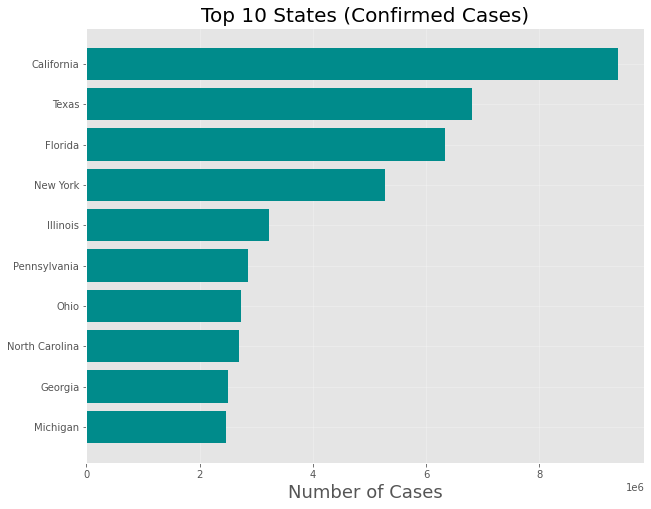

In [18]:
# horizontal bar chart of top ten states for cases

plt.figure(figsize=(10,8))
plt.barh(top_10_cases['state'], top_10_cases['cases'], color='darkcyan')
plt.xlabel('Number of Cases', fontsize=18)
plt.title('Top 10 States (Confirmed Cases)', size=20)
plt.grid(alpha=0.3)
plt.show()

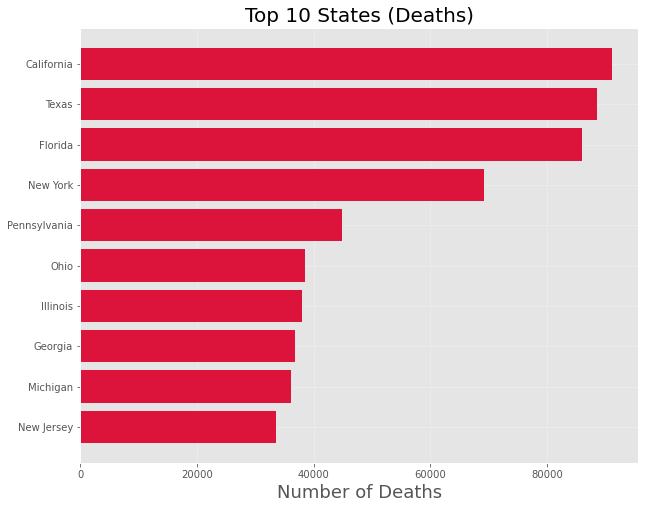

In [19]:
# horizontal bar chart of top ten states for deaths

plt.figure(figsize=(10,8))
plt.barh(top_10_deaths['state'], top_10_deaths['deaths'], color='crimson')
plt.xlabel('Number of Deaths', fontsize=18)
plt.title('Top 10 States (Deaths)', size=20)
plt.grid(alpha=0.3)
plt.show()

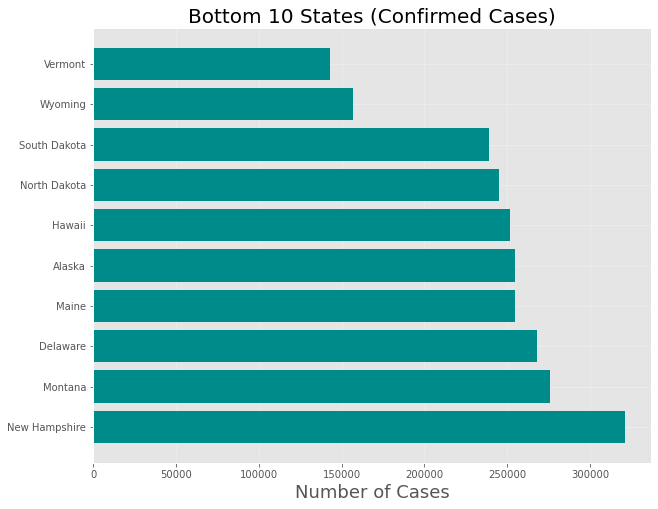

In [20]:
# horizontal bar chart for bottom 10 states for cases

plt.figure(figsize=(10,8))
plt.barh(bottom_10_cases['state'], bottom_10_cases['cases'], color='darkcyan')
plt.xlabel('Number of Cases', fontsize=18)
plt.title('Bottom 10 States (Confirmed Cases)', size=20)
plt.grid(alpha=0.3)
plt.show()

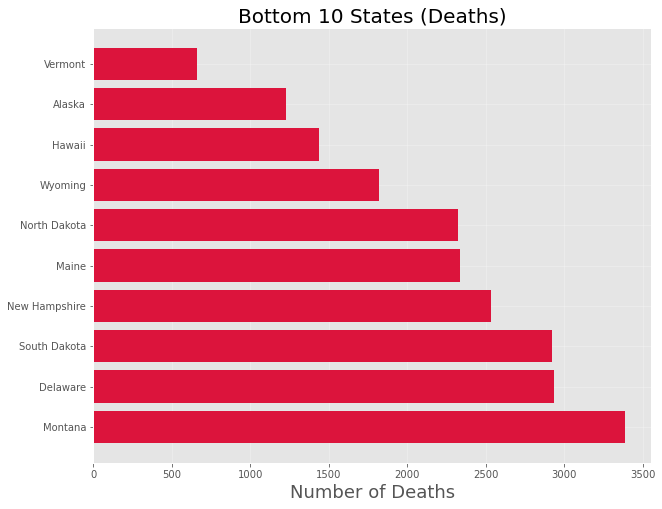

In [21]:
# horizontal bar chart for bottom 10 states for deaths

plt.figure(figsize=(10,8))
plt.barh(bottom_10_deaths['state'], bottom_10_deaths['deaths'], color='crimson')
plt.xlabel('Number of Deaths', fontsize=18)
plt.title('Bottom 10 States (Deaths)', size=20)
plt.grid(alpha=0.3)
plt.show()

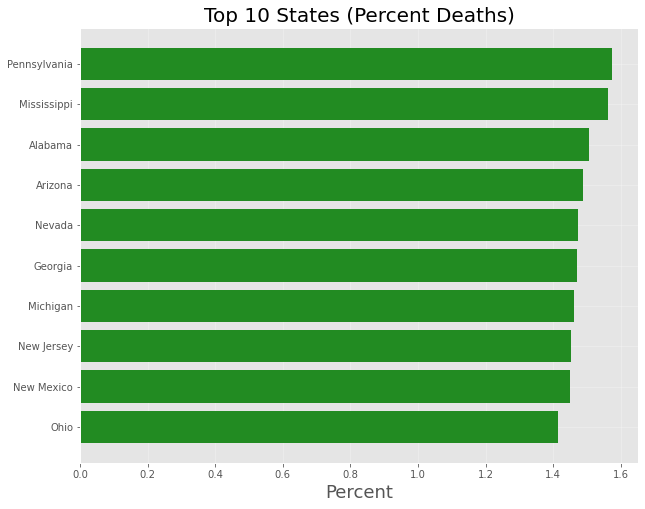

In [22]:
# top 5 percent deaths from confirmed cases

plt.figure(figsize=(10,8))
plt.barh(top_10_percent_deaths['state'], top_10_percent_deaths['percent deaths'], color='forestgreen')
plt.xlabel('Percent', fontsize=18)
plt.title('Top 10 States (Percent Deaths)', size=20)
plt.grid(alpha=0.3)
plt.show()

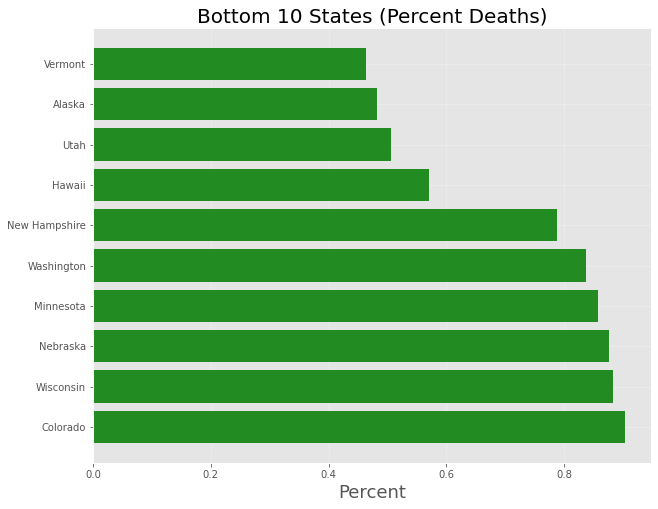

In [23]:
# bottom 5 percent deaths from confirmed cases

plt.figure(figsize=(10,8))
plt.barh(bottom_10_percent_deaths['state'], bottom_10_percent_deaths['percent deaths'], color='forestgreen')
plt.xlabel('Percent', fontsize=18)
plt.title('Bottom 10 States (Percent Deaths)', size=20)
plt.grid(alpha=0.3)
plt.show()

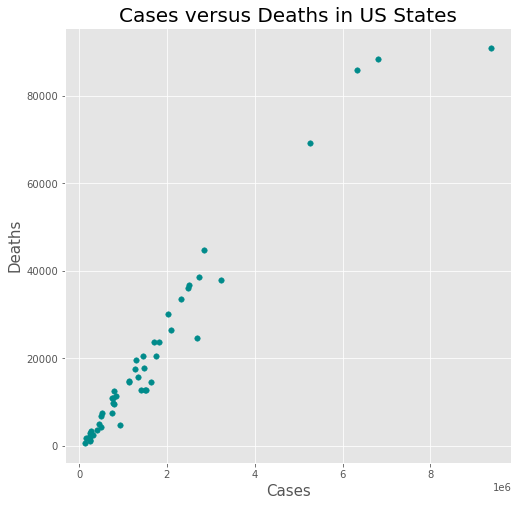

In [24]:
# scatter plots of latest cases versus deaths

fig = plt.figure(figsize=(8,8))
plt.scatter(df_recent['cases'], df_recent['deaths'], label='test', color='darkcyan', marker='o', s=30)
plt.xlabel('Cases', size=15)
plt.ylabel('Deaths', size=15)
plt.title('Cases versus Deaths in US States', size=20)
plt.show()

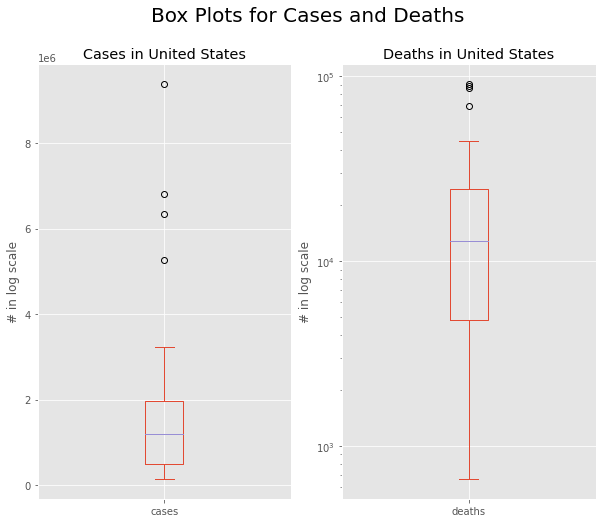

In [32]:
# box plots for distribution of cases and deaths in US

fig, axes = plt.subplots(1, 2, figsize=(10,8))

df_recent['cases'].plot(kind='box', ax=axes[0])
axes[0].set_title('Cases in United States')
axes[0].set_ylabel('# in log scale')
df_recent['deaths'].plot(kind='box', ax=axes[1])
axes[1].set_title('Deaths in United States')
axes[1].set_ylabel('# in log scale')
plt.yscale('log')
plt.suptitle('Box Plots for Cases and Deaths', size=20)

plt.show()

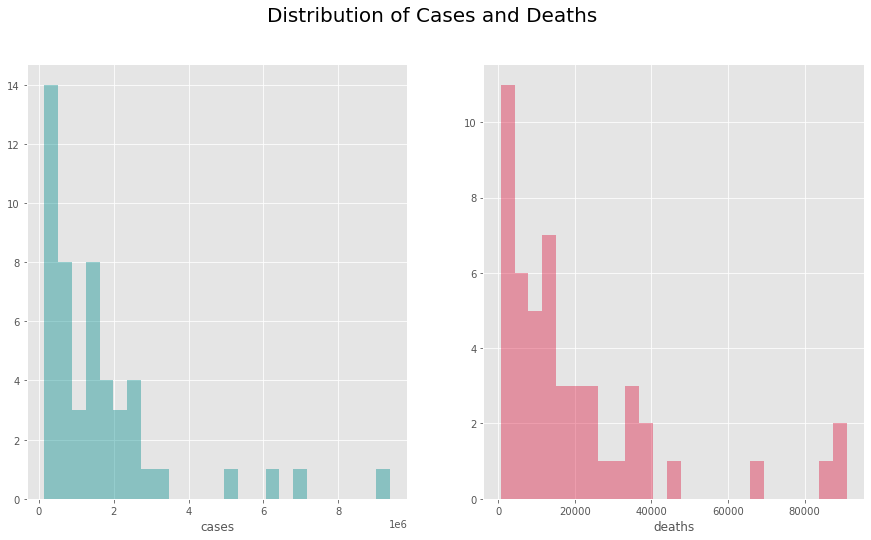

In [33]:
# distribution plots for cases and deaths

fig, axes = plt.subplots(1, 2, figsize=(15,8))

sns.distplot(df_recent['cases'], kde=False, bins=25, ax=axes[0], color='darkcyan')
sns.distplot(df_recent['deaths'], kde=False, bins=25, ax=axes[1], color='crimson')
plt.suptitle('Distribution of Cases and Deaths', size=20)
plt.show()

<Figure size 576x576 with 0 Axes>

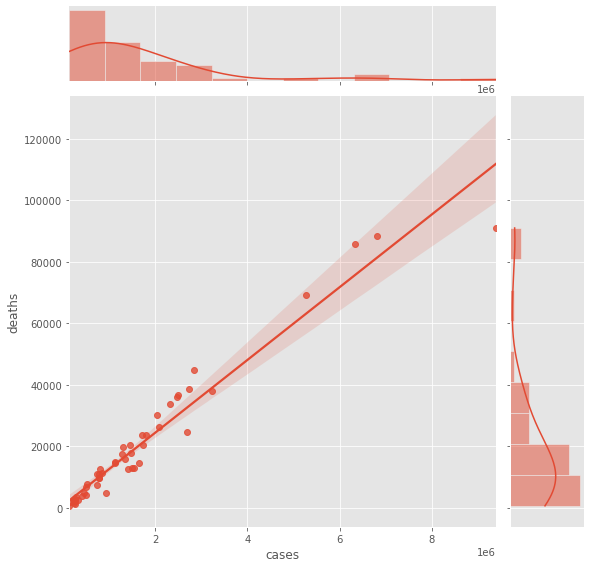

In [34]:
# seaborn jointplot for cases and deaths

fig = plt.figure(figsize=(8,8))
sns.jointplot('cases', 'deaths', data=df_recent, kind='reg', height=8)
plt.show()

In [35]:
df_recent.iloc[:,:].corr().style.background_gradient(cmap='Reds').format('{:.3f}')

,cases,deaths,percent deaths
cases,1.000,0.974,0.208
deaths,0.974,1.000,0.349
percent deaths,0.208,0.349,1.000


In [36]:
df_los_angeles = df[df['county'] == 'Los Angeles']

In [37]:
count_cases_los_angeles = df_los_angeles['cases'].max()
count_deaths_los_angeles = int(df_los_angeles['deaths'].max())

print('Total cases in Los Angeles:', str(count_cases_los_angeles))
print('Total deaths in Los Angeles', str(count_deaths_los_angeles))

Total cases in Los Angeles: 2908425
Total deaths in Los Angeles 32022


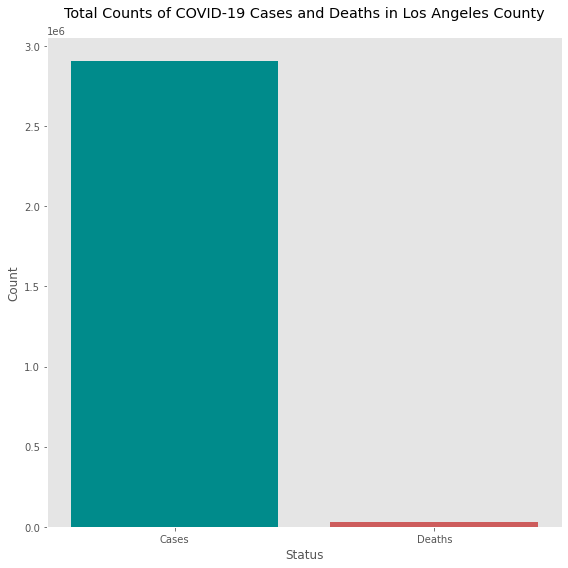

In [38]:
status = ['Cases', 'Deaths']
count = [count_cases_los_angeles, count_deaths_los_angeles]

fig, axes  = plt.subplots(figsize=(8,8))
axes.bar(status, count, color=['darkcyan', 'indianred'])
axes.set_title('Total Counts of COVID-19 Cases and Deaths in Los Angeles County', pad=20)
axes.set_xlabel('Status')
axes.set_ylabel('Count')
plt.grid(False)
plt.tight_layout()
plt.show()

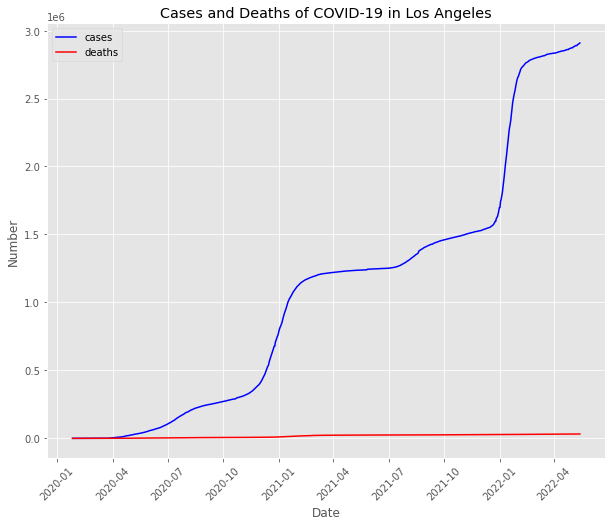

In [39]:
plt.figure(figsize=(10,8))
plt.plot(df_los_angeles['date'], df_los_angeles['cases'], label='cases', color='b')
plt.plot(df_los_angeles['date'], df_los_angeles['deaths'], label='deaths', color='r')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Number')
plt.title('Cases and Deaths of COVID-19 in Los Angeles')
plt.legend()
plt.show()

In [40]:
los_angeles_population = 10014009

los_angeles_recent_cases = np.max(df_los_angeles['cases'])
los_angeles_case_percent = round(los_angeles_recent_cases/los_angeles_population * 100, 2)

los_angeles_deaths_percent = round(count_deaths_los_angeles / los_angeles_population * 100, 2)
los_angeles_deaths_per_hundred_thousand = int(los_angeles_deaths_percent * 1000)

print('Percentage of total confirmed cases in Los Angeles County: ' + str(los_angeles_case_percent) + '%')
print('Mortality rate COVID-19 per hundred thousand in Los Angeles County:', los_angeles_deaths_per_hundred_thousand)

Percentage of total confirmed cases in Los Angeles County: 29.04%
Mortality rate COVID-19 per hundred thousand in Los Angeles County: 320


In [41]:
# DataFrame summing up counties in California for cases and deaths
df_california = df[df['state'] == 'California']
date_list = []
cases_list = []
deaths_list = []

for day in df_california['date'].unique():
    date_list.append(day)
    cases_list.append(df_california[df_california['date'] == day]['cases'].sum())
    deaths_list.append(df_california[df_california['date'] == day]['deaths'].sum())
    
    
data = {'date': date_list, 'cases': cases_list, 'deaths': deaths_list}
df_total_california = pd.DataFrame(data, columns=['date', 'cases', 'deaths'])
df_total_california.sort_values('date', inplace=True)
df_total_california.reset_index(inplace=True, drop=True)

In [42]:
df_total_california['percent deaths'] = df_total_california['deaths'] / df_total_california['cases'] * 100

In [43]:
df_total_california.tail(10)

,date,cases,deaths,percent deaths
830,2022-05-04,9265196,90571.0,0.977540
831,2022-05-05,9268144,90581.0,0.977337
832,2022-05-06,9290532,90704.0,0.976306
833,2022-05-07,9290555,90704.0,0.976303
834,2022-05-08,9290555,90706.0,0.976325
835,2022-05-09,9297615,90712.0,0.975648
836,2022-05-10,9322169,90822.0,0.974258
837,2022-05-11,9325522,90804.0,0.973715
838,2022-05-12,9329044,90818.0,0.973497
839,2022-05-13,9351630,90959.0,0.972654


In [44]:
df_total_california.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            840 non-null    datetime64[ns]
 1   cases           840 non-null    int64         
 2   deaths          840 non-null    float64       
 3   percent deaths  840 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 26.4 KB


In [45]:
df_total_california.describe()

,cases,deaths,percent deaths
count,8.400000e+02,840.000000,840.000000
mean,3.345382e+06,43970.794048,1.641899
std,2.882682e+06,31484.949465,0.803842
min,1.000000e+00,0.000000,0.000000
25%,6.639915e+05,12098.750000,1.233742
50%,3.639736e+06,57456.000000,1.537838
75%,4.828592e+06,70769.000000,1.834913
max,9.351630e+06,90959.000000,4.144647


In [46]:
latest_cases_california = df_total_california['cases'].max()
latest_deaths_california = int(df_total_california['deaths'].max())

print('Current cases in California:', latest_cases_california)
print('Current deaths in California:', latest_deaths_california)

Current cases in California: 9351630
Current deaths in California: 90959


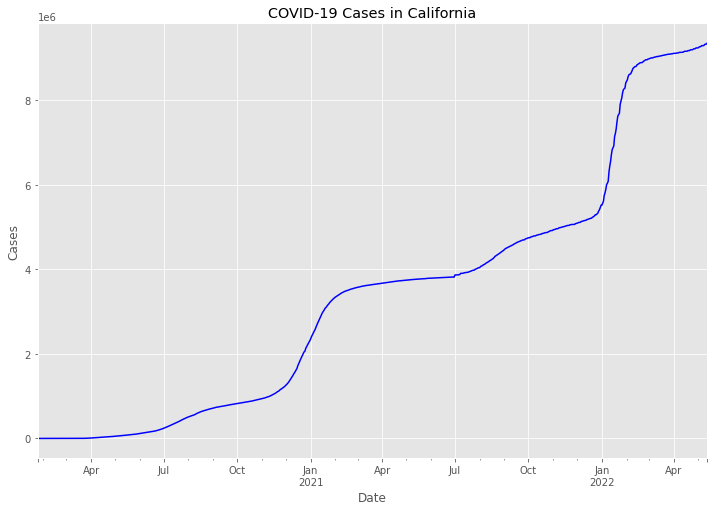

In [47]:
df_total_california.plot('date', 'cases', color='b', figsize=(12, 8), legend=False)
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('COVID-19 Cases in California')
plt.show()

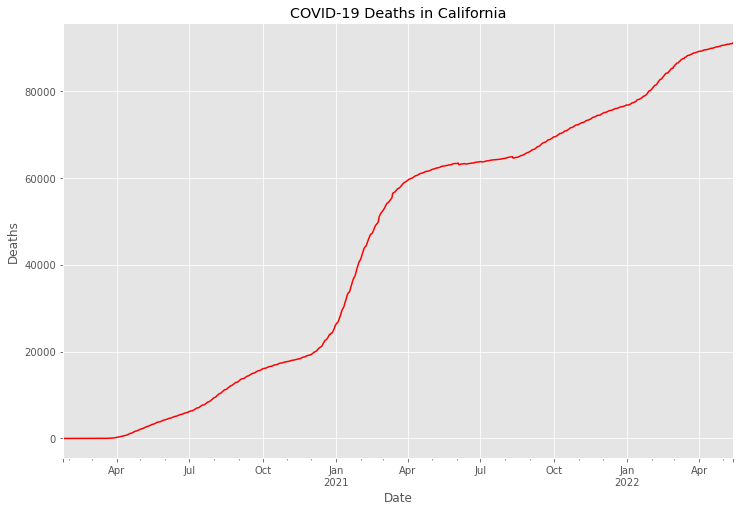

In [48]:
df_total_california.plot('date', 'deaths', color='r', figsize=(12, 8), legend=False)
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.title('COVID-19 Deaths in California')
plt.show()

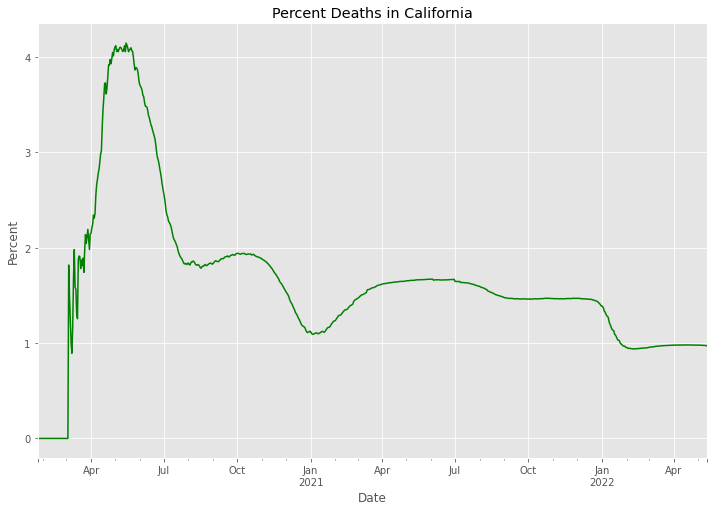

In [49]:
df_total_california.plot('date', 'percent deaths', color='g', figsize=(12,8), legend=False)
plt.xlabel('Date')
plt.ylabel('Percent')
plt.title('Percent Deaths in California')
plt.show()

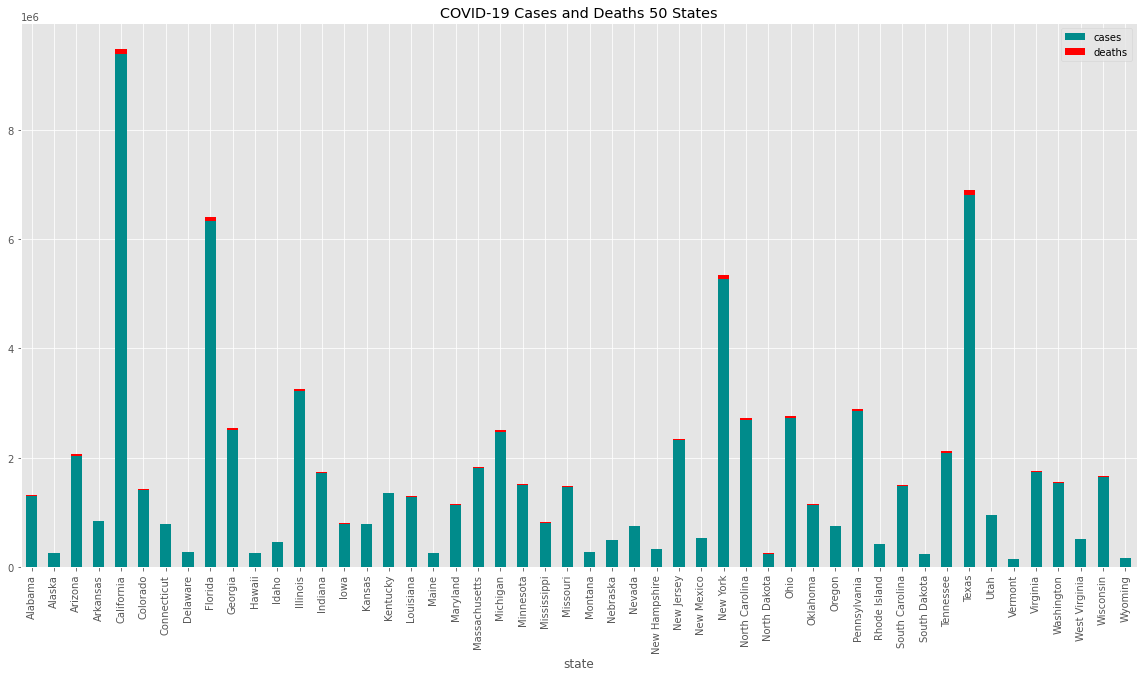

In [50]:
x= df_recent[['state','cases','deaths']]
y= x.set_index('state')
z=y.groupby('state').mean()

z.plot(kind='bar', stacked=True, color=['darkcyan', 'red'], figsize=(20,10))
plt.title('COVID-19 Cases and Deaths 50 States')
plt.show()

In [51]:
# function to sum counties in state

def total_state(df, state):

    df_state = df[df['state'] == state]
    date_list = []
    cases_list = []
    deaths_list = []

    for day in df_state['date'].unique():
        date_list.append(day)
        cases_list.append(df_state[df_state['date'] == day]['cases'].sum())
        deaths_list.append(df_state[df_state['date'] == day]['deaths'].sum())


    data = {'date': date_list, 'cases': cases_list, 'deaths': deaths_list}
    df_total_state = pd.DataFrame(data, columns=['date', 'cases', 'deaths'])
    df_total_state['percent deaths'] = df_total_state['deaths'] / df_total_state['cases'] * 100
    df_total_state.dropna(axis=0, inplace=True)
    df_total_state.sort_values('date', axis=0, inplace=True)
    df_total_state.reset_index(inplace=True, drop=True)
    
    return df_total_state

In [52]:
# function to retrieve county

def county(df, state, county):
    
    df_state = df[df['state'] == state]
    df_county = df_state[df_state['county'] == county]
    
    return df_county

In [53]:
def replace_negative(x):
    if x < 0:
        return 0
    else:
        return x

In [54]:
# moving average function

def moving_average(data, window_size=7):
    moving_average = []
    for i in range(len(data)):
        if (i + window_size < len(data)) and i > 7:
            moving_average.append(np.mean(data[i-window_size:i]))
        else:
            moving_average.append(None) 
    return moving_average

In [55]:
def plot_moving_avg_cases(df, name):
    
    df['cases daily'] = df['cases'].diff()
    df.fillna(0, axis=1, inplace=True)
    df['cases daily'] = df['cases daily'].astype(np.int64)
    df['cases daily'] = df['cases daily'].apply(replace_negative)
    daily_confirmed_avg = moving_average(df['cases daily'])
   
    
    plt.figure(figsize=(15, 8))
    plt.bar(df['date'], df['cases daily'], color='blue')
    plt.plot(df['date'], daily_confirmed_avg, color='orange', linewidth=4, linestyle='dashed')
    plt.title(name + ' Daily Increases in Confirmed Cases', size=30)
    plt.xlabel('Date', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.legend(['Moving Average 7 Days ' + name + ' Daily Increase in COVID-19 Cases'], prop={'size':15})
    plt.xticks(size=20, rotation=45)
    plt.yticks(size=20)
    plt.ylim(top=np.max(df['cases daily']))
    #plt.tight_layout(True)
    plt.show()

In [56]:
def plot_moving_avg_deaths(df, name):
    
    df['deaths daily'] = df['deaths'].diff()
    df.fillna(0, inplace=True)
    df['deaths daily'] = df['deaths daily'].astype(np.int64)
    df['deaths daily'] = df['deaths daily'].apply(replace_negative)
    daily_confirmed_avg = moving_average(df['deaths daily'])
   
    
    plt.figure(figsize=(15,8))
    plt.bar(df['date'], df['deaths daily'], color='red')
    plt.plot(df['date'], daily_confirmed_avg, color='green', linewidth=4, linestyle='dashed')
    plt.title(name + ' Daily Increases in Confirmed Deaths', size=30)
    plt.xlabel('Date', size=30)
    plt.ylabel('# of Deaths', size=30)
    plt.legend(['Moving Average 7 Days ' + name + ' Daily Increase in COVID-19 Deaths'], prop={'size':15})
    plt.xticks(size=20, rotation=45)
    plt.yticks(size=20)
    plt.ylim(top=np.max(df['deaths daily']))
    plt.ylim(bottom=0)
    #plt.tight_layout(True)
    plt.show()

In [57]:
df_texas = total_state(df, 'Texas')
df_florida = total_state(df, 'Florida')
df_california = total_state(df, 'California')
df_massachusetts = total_state(df, 'Massachusetts')
df_ny = total_state(df, 'New York')

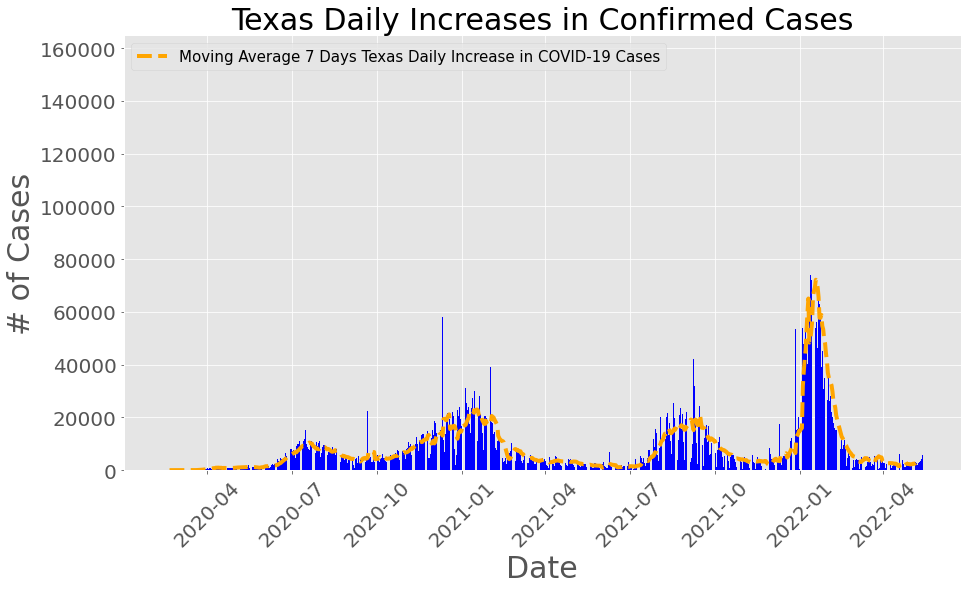

In [58]:
plot_moving_avg_cases(df_texas, 'Texas')

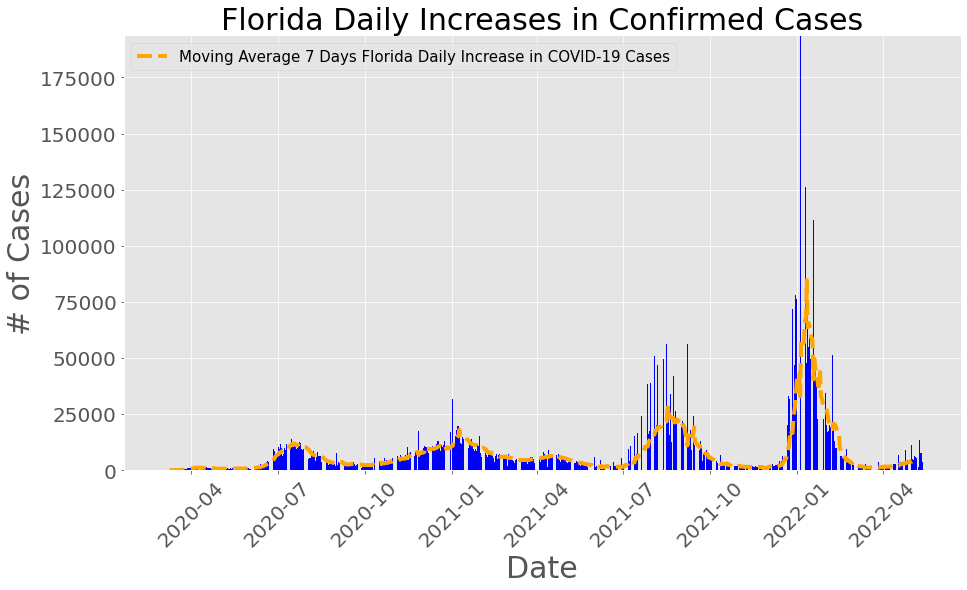

In [59]:
plot_moving_avg_cases(df_florida, 'Florida')

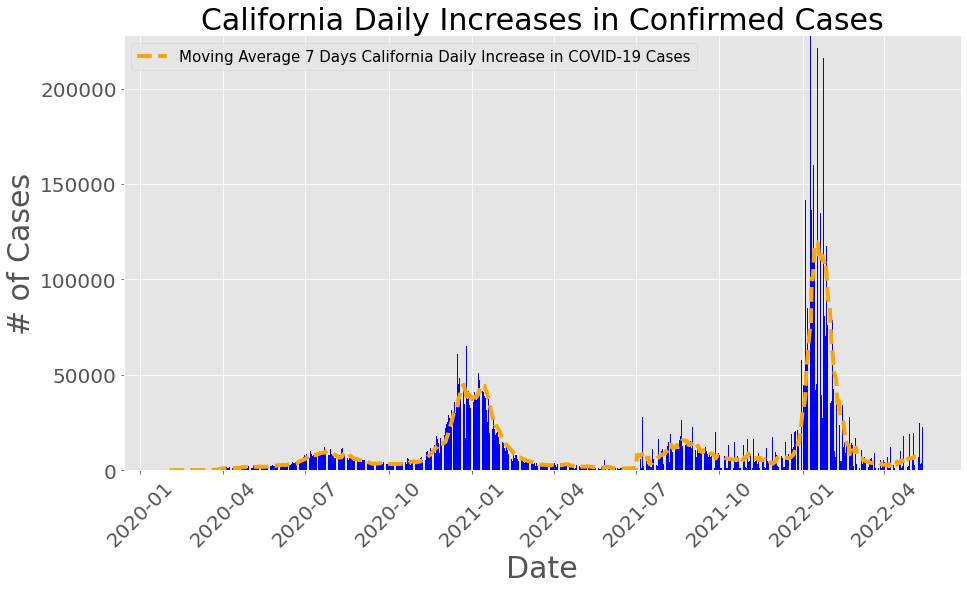

In [60]:
plot_moving_avg_cases(df_california, 'California')

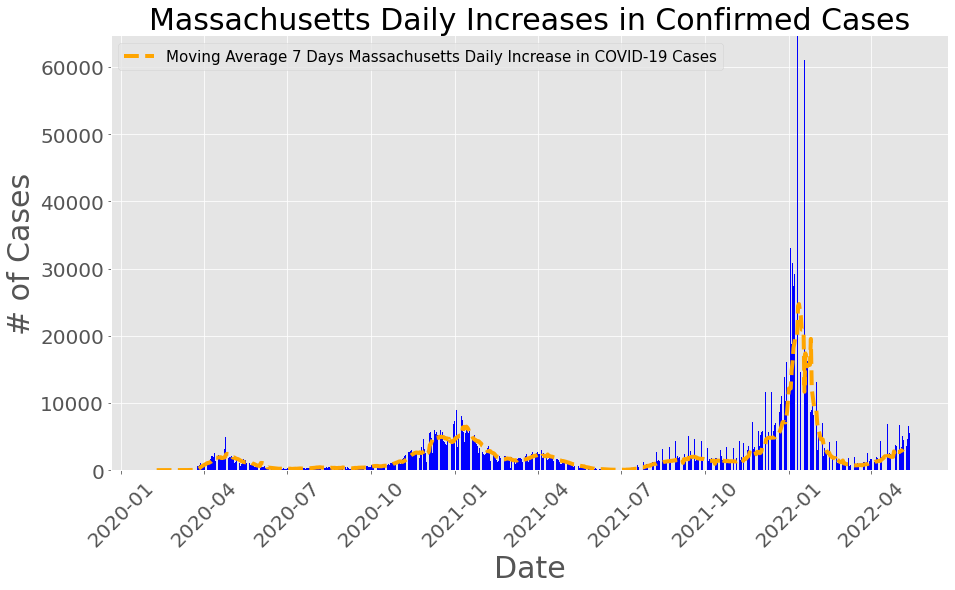

In [61]:
plot_moving_avg_cases(df_massachusetts, 'Massachusetts')

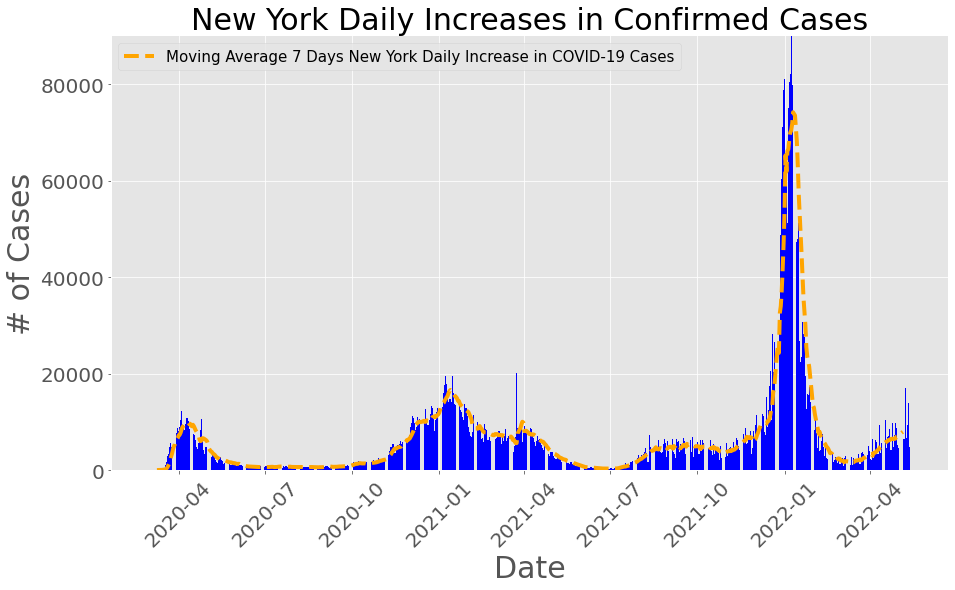

In [62]:
plot_moving_avg_cases(df_ny, 'New York')

In [63]:
df[df['state'] == 'California']['county'].unique()

array(['Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras', 'Colusa',
       'Contra Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn',
       'Humboldt', 'Imperial', 'Inyo', 'Kern', 'Kings', 'Lake', 'Lassen',
       'Los Angeles', 'Madera', 'Marin', 'Mariposa', 'Mendocino',
       'Merced', 'Modoc', 'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange',
       'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito',
       'San Bernardino', 'San Diego', 'San Francisco', 'San Joaquin',
       'San Luis Obispo', 'San Mateo', 'Santa Barbara', 'Santa Clara',
       'Santa Cruz', 'Shasta', 'Sierra', 'Siskiyou', 'Solano', 'Sonoma',
       'Stanislaus', 'Sutter', 'Tehama', 'Trinity', 'Tulare', 'Tuolumne',
       'Unknown', 'Ventura', 'Yolo', 'Yuba'], dtype=object)

In [64]:
df_los_angeles = county(df, 'California', 'Los Angeles')
df_san_diego = county(df, 'California', 'San Diego')
df_san_francisco = county(df, 'California', 'San Francisco')
df_santa_barbara = county(df, 'California', 'Santa Barbara')
df_san_bernadino = county(df, 'California', 'San Bernadino')
df_orange = county(df, 'California', 'Orange')
df_kern = county(df, 'California', 'Kern')

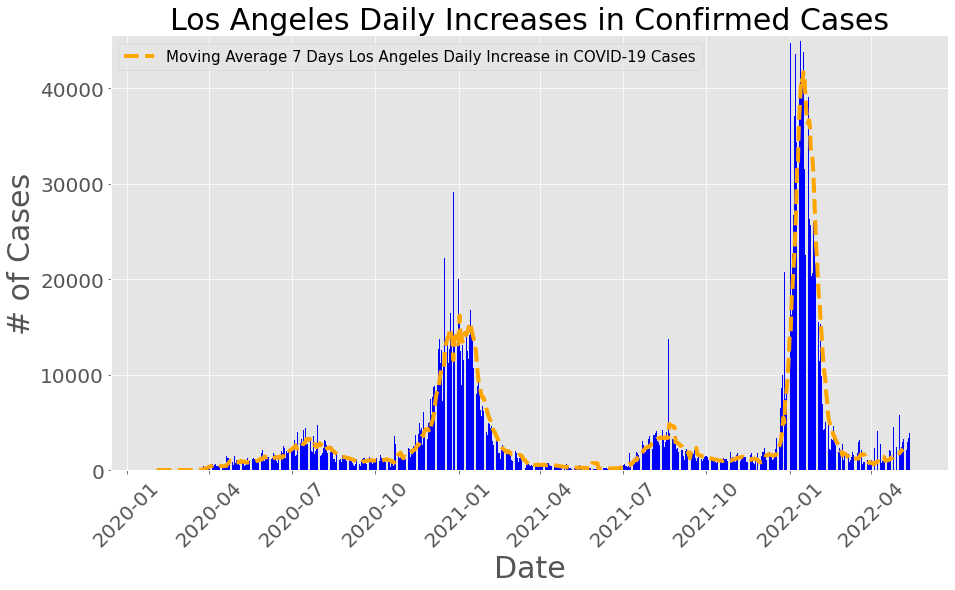

In [65]:
plot_moving_avg_cases(df_los_angeles, 'Los Angeles')

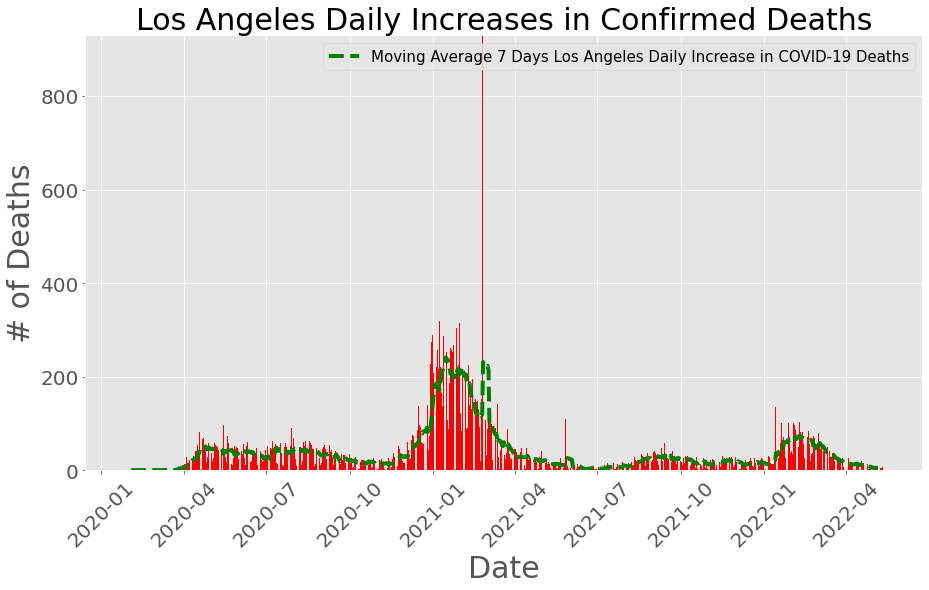

In [66]:
plot_moving_avg_deaths(df_los_angeles, 'Los Angeles')

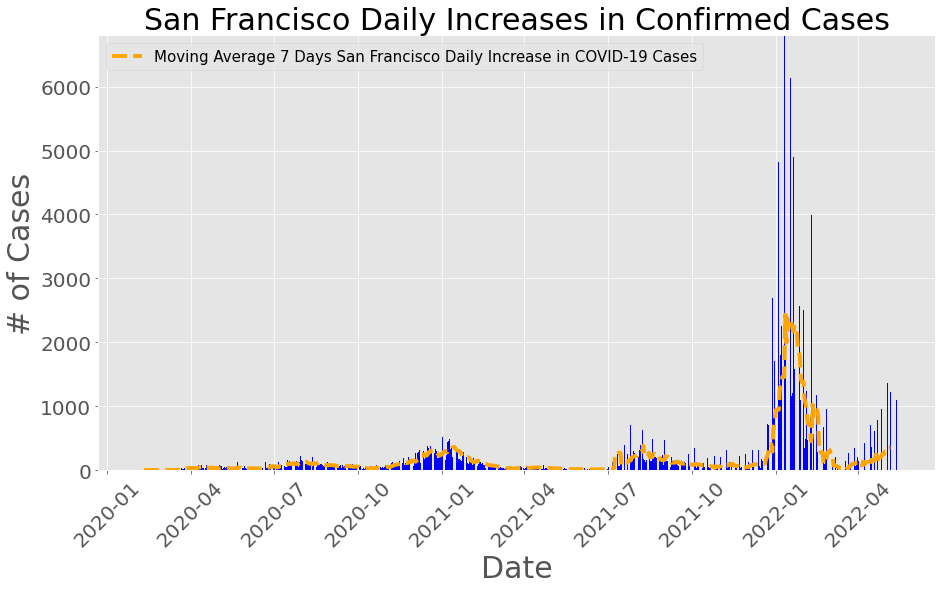

In [67]:
plot_moving_avg_cases(df_san_francisco, 'San Francisco')

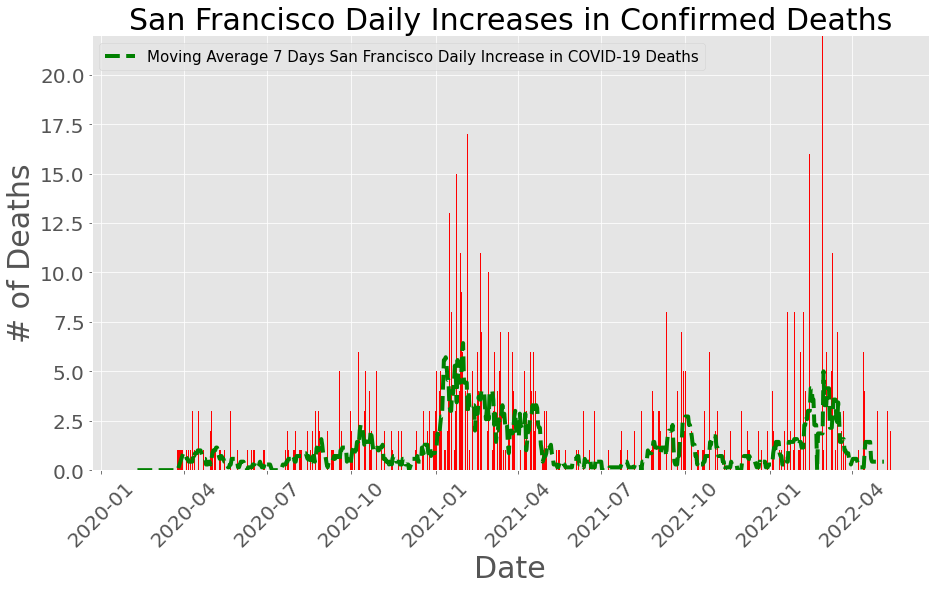

In [68]:
plot_moving_avg_deaths(df_san_francisco, 'San Francisco')

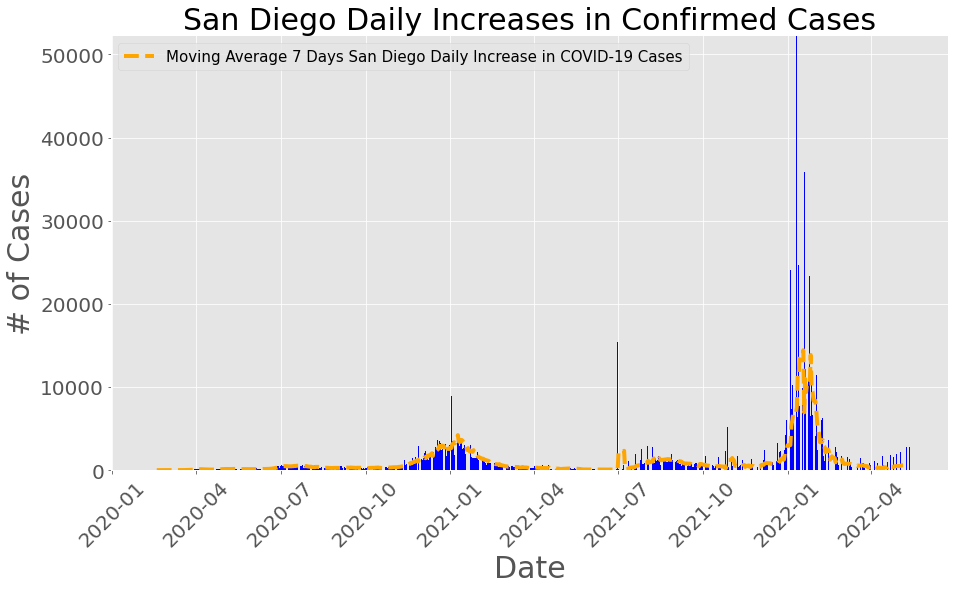

In [69]:
plot_moving_avg_cases(df_san_diego, 'San Diego')

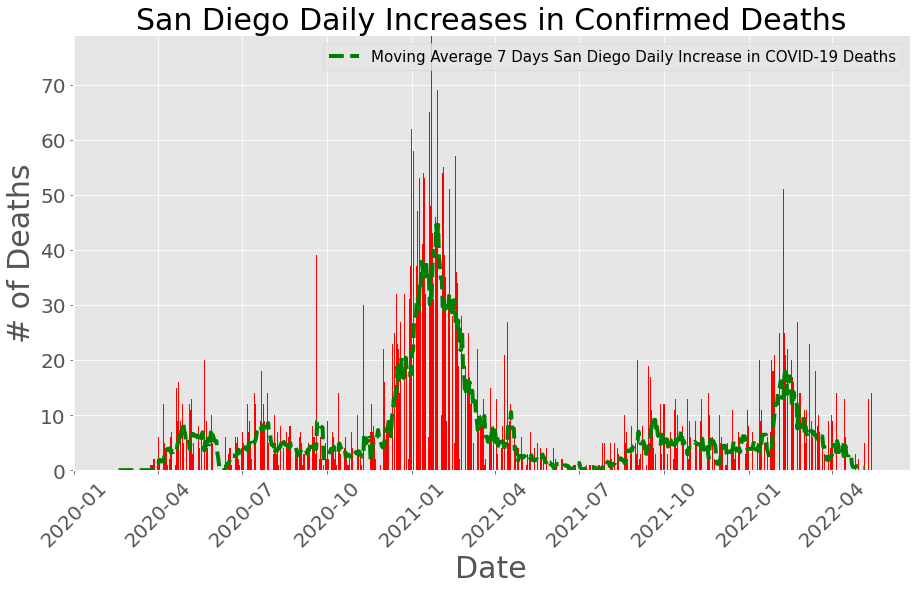

In [70]:
plot_moving_avg_deaths(df_san_diego, 'San Diego')

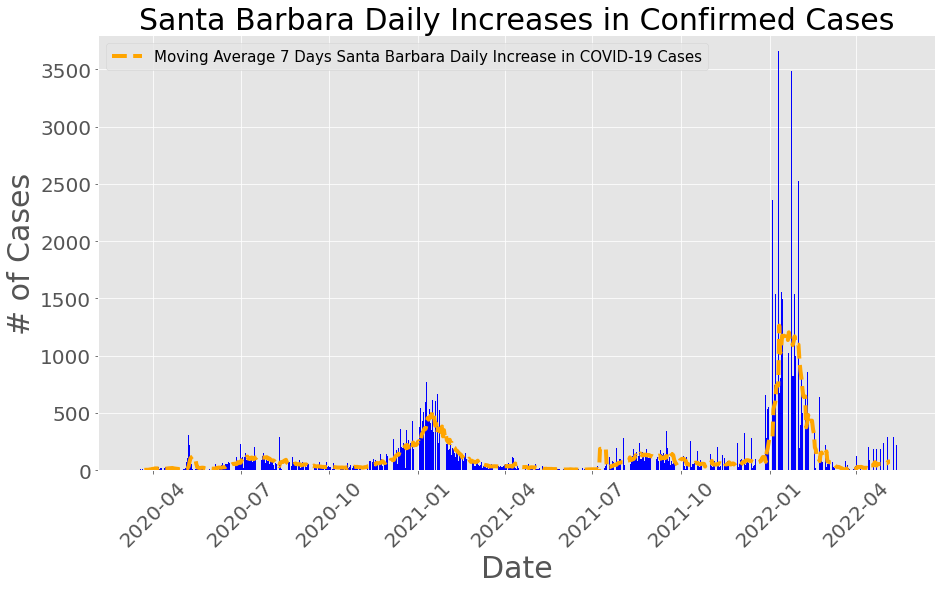

In [71]:
plot_moving_avg_cases(df_santa_barbara, 'Santa Barbara')

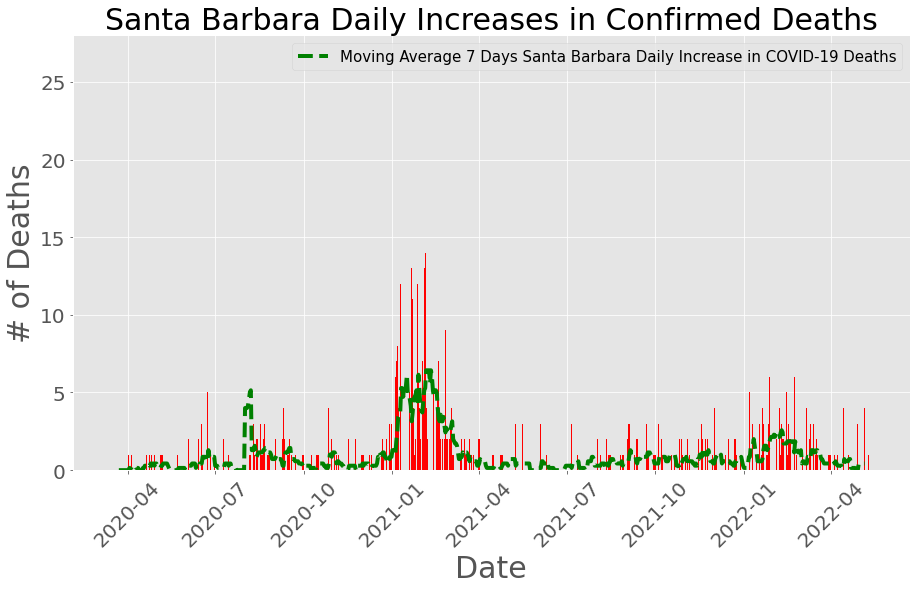

In [72]:
plot_moving_avg_deaths(df_santa_barbara, 'Santa Barbara')

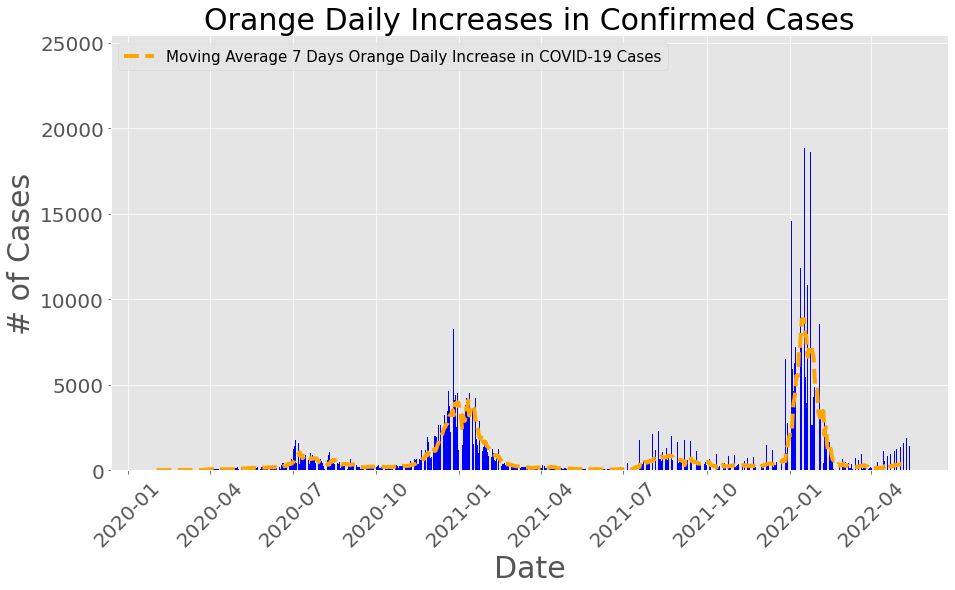

In [73]:
plot_moving_avg_cases(df_orange, 'Orange')

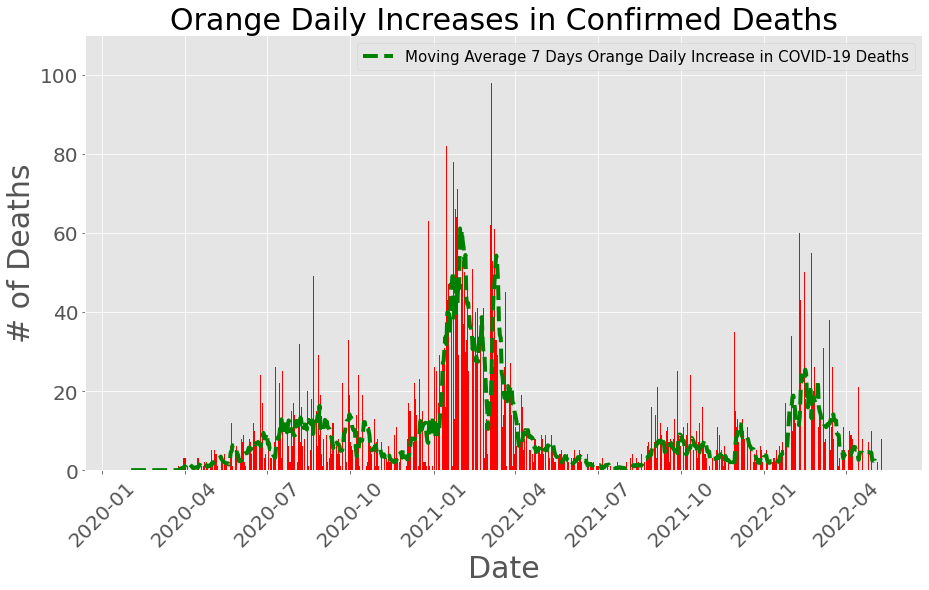

In [74]:
plot_moving_avg_deaths(df_orange, 'Orange')

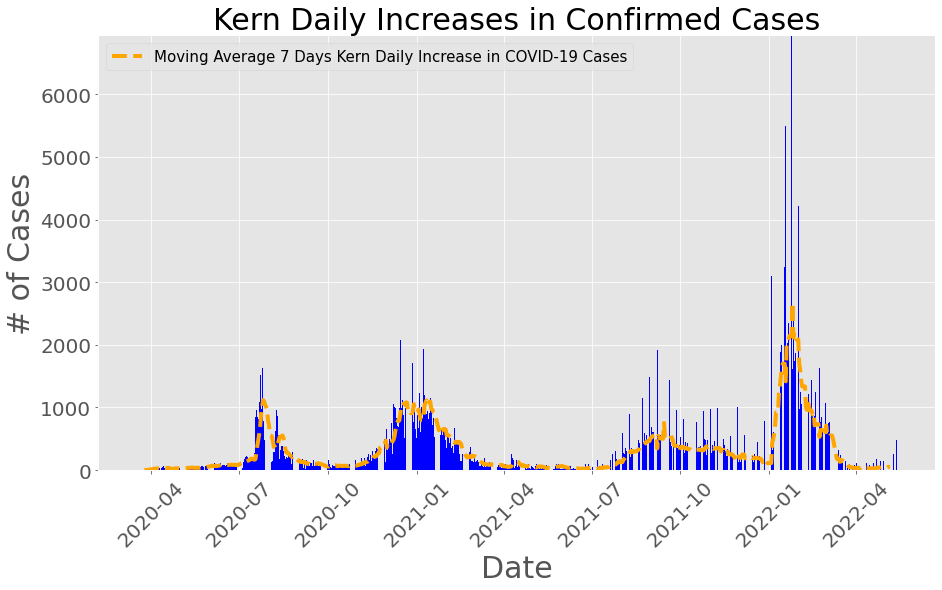

In [75]:
plot_moving_avg_cases(df_kern, 'Kern')

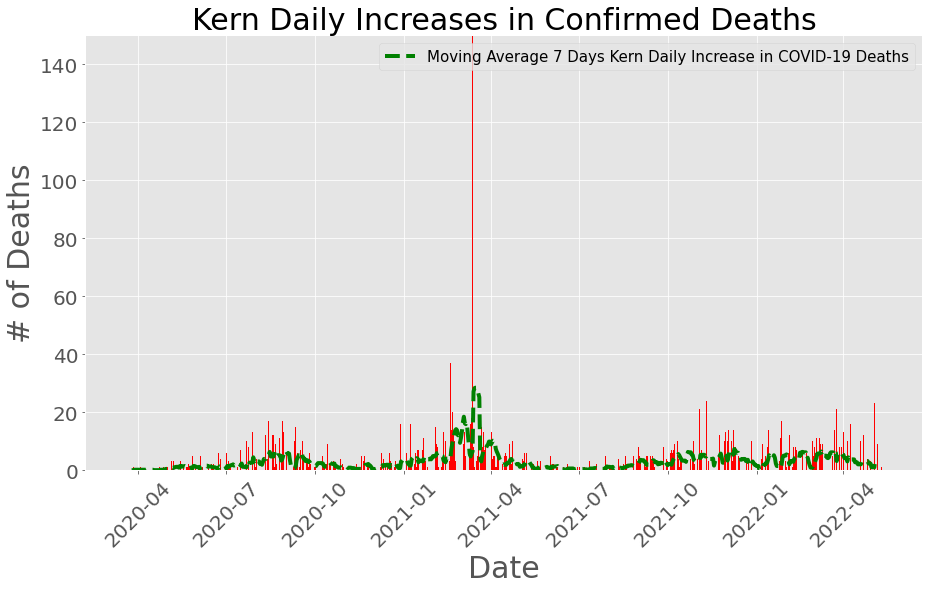

In [76]:
plot_moving_avg_deaths(df_kern, 'Kern')

### Time Series Analysis and Forecasting with Prophet

In [77]:
ts_los_angeles = county(df, 'California', 'Los Angeles')
ts_los_angeles['daily cases'] = ts_los_angeles['cases'].diff()
ts_los_angeles.drop(['county', 'state', 'cases', 'deaths'], axis=1, inplace=True)
ts_los_angeles.reset_index(inplace=True, drop=True)
ts_los_angeles.drop(index=0, axis=0, inplace=True)
ts_los_angeles.set_index('date', inplace=True)

In [78]:
ts_los_angeles.tail(10)

,daily cases
date,
2022-05-04,2462.0
2022-05-05,2896.0
2022-05-06,3233.0
2022-05-07,0.0
2022-05-08,0.0
2022-05-09,6992.0
2022-05-10,2113.0
2022-05-11,2936.0
2022-05-12,3330.0


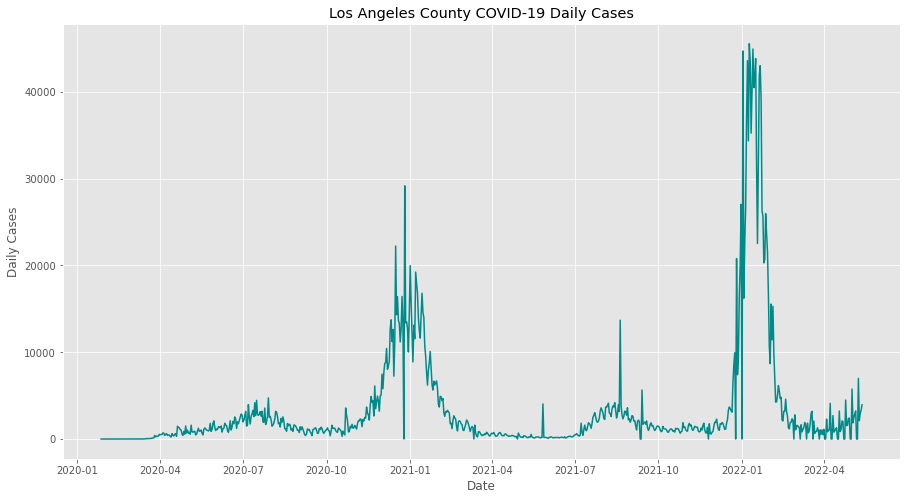

In [79]:
fig = plt.figure(figsize=(15,8))

plt.plot(ts_los_angeles.index, ts_los_angeles['daily cases'], color='darkcyan')
plt.xlabel('Date')
plt.ylabel('Daily Cases')
plt.title('Los Angeles County COVID-19 Daily Cases')
plt.show()

In [80]:
ss_decomposition = seasonal_decompose(x=ts_los_angeles, model='additive', period=3)

In [81]:
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

In [82]:
data = {'trend': estimated_trend, 'seasonal': estimated_seasonal, 'residual': estimated_residual}
composition = pd.DataFrame(data, columns=['trend', 'seasonal', 'residual'], index=estimated_trend.index)
composition.tail(10)

,trend,seasonal,residual
date,,,
2022-05-04,2405.000000,-21.240166,78.240166
2022-05-05,2863.666667,120.302879,-87.969546
2022-05-06,2043.000000,-99.062713,1289.062713
2022-05-07,1077.666667,-21.240166,-1056.426500
2022-05-08,2330.666667,120.302879,-2450.969546
2022-05-09,3035.000000,-99.062713,4056.062713
2022-05-10,4013.666667,-21.240166,-1879.426500
2022-05-11,2793.000000,120.302879,22.697121
2022-05-12,3402.666667,-99.062713,26.396046


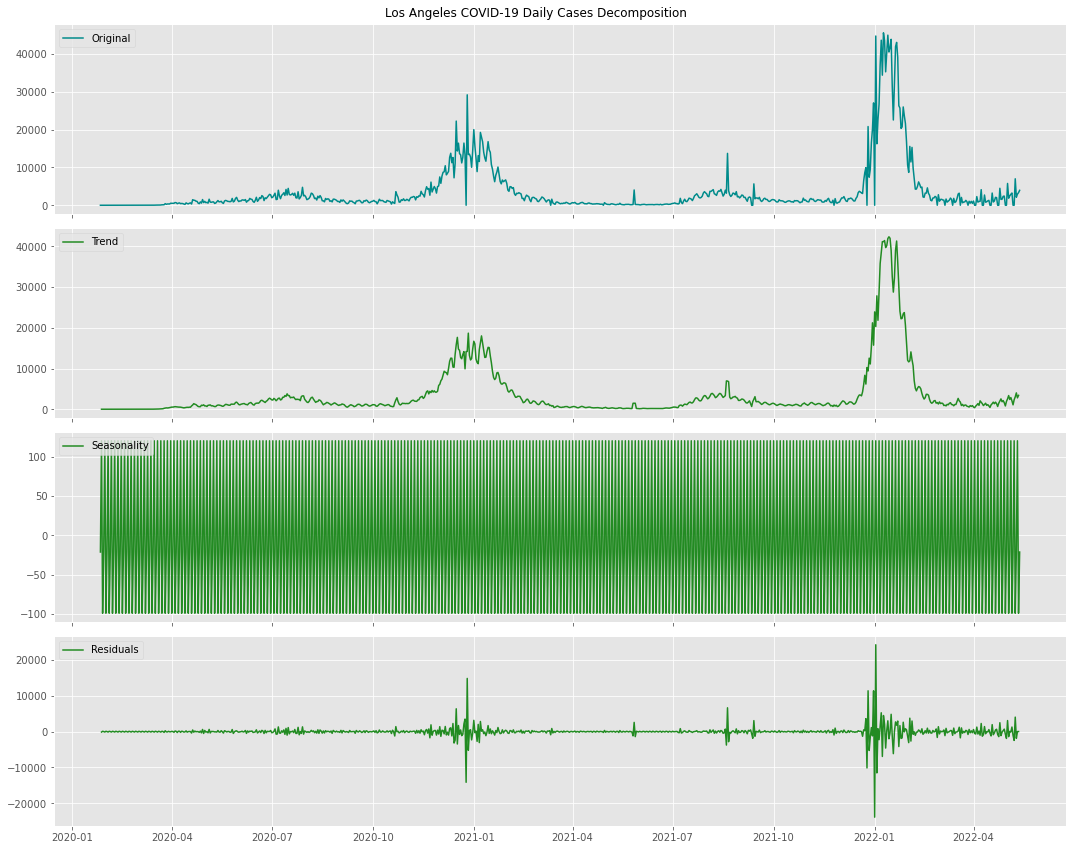

In [83]:
fig, axes = plt.subplots(4, 1, figsize=(15,12), sharex=True, sharey=False)

axes[0].plot(ts_los_angeles, label='Original', color='darkcyan')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend', color='forestgreen')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality', color='forestgreen')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals', color='forestgreen')
axes[3].legend(loc='upper left');

plt.suptitle('Los Angeles COVID-19 Daily Cases Decomposition')
plt.tight_layout()
plt.show()

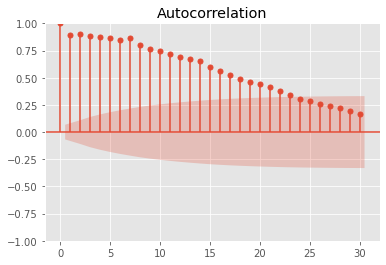

In [84]:
plot_acf(ts_los_angeles);

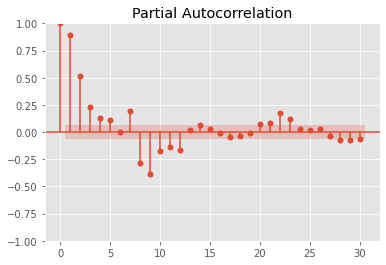

In [85]:
plot_pacf(ts_los_angeles);

In [86]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(ts_los_angeles)

In [87]:
print('Summary Statistics - Dickey Fuller')
print('----------------------------------')
print('adf:', adf)
print('p-value:', pvalue)
print('usedlag:', usedlag)
print('number of observations:', nobs)
print('critical values:', critical_values)
print('icbest:', icbest)

Summary Statistics - Dickey Fuller
----------------------------------
adf: -3.6140335566596993
p-value: 0.005498334940603462
usedlag: 21
number of observations: 816
critical values: {'1%': -3.4383892038884722, '5%': -2.8650884667384955, '10%': -2.568659512747501}
icbest: 14896.128450451937


In [88]:
data = {'ds': pd.to_datetime(ts_los_angeles.index), 'y': ts_los_angeles['daily cases']}
los_angeles_prophet = pd.DataFrame(data, columns=['ds', 'y'])
#los_angeles_prophet['floor'] = 0
#los_angeles_prophet['cap'] = 50000
los_angeles_prophet.reset_index(drop=True, inplace=True)
los_angeles_prophet.tail(10)

,ds,y
828,2022-05-04,2462.0
829,2022-05-05,2896.0
830,2022-05-06,3233.0
831,2022-05-07,0.0
832,2022-05-08,0.0
833,2022-05-09,6992.0
834,2022-05-10,2113.0
835,2022-05-11,2936.0
836,2022-05-12,3330.0
837,2022-05-13,3942.0


In [89]:
los_angeles_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      838 non-null    datetime64[ns]
 1   y       838 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.2 KB


In [90]:
# specify holidays for 2020 and 2021

dates_2020 = ['2020-01-01', '2020-02-17', '2020-03-17', '2020-04-12', '2020-05-05', '2020-05-25',
                '2020-07-04', '2020-09-07', '2020-10-31', '2020-11-26', '2020-12-25', '2020-12-31']
dates_2021 = ['2021-01-01', '2021-02-15', '2021-03-17', '2021-04-04', '2021-05-05', '2021-05-31', 
                '2021-07-04', '2021-09-06', '2021-10-31', '2021-11-25', '2021-12-25', '2021-12-31']
#dates_2022 = ['2022-01-01', '2022-02-14', '2022-03-17', '2022-04-17', '2022-05-05', '2022-05-30', 
#             '2022-07-04', '2022-09-05', '2022-10-31', '2022-11-24', '2022-12-25', '2022-12-31']
dates_2022 = ['2022-01-01', '2022-02-14', '2022-03-17', '2022, 04-17', '2022-05-05']

holidays_2020 = pd.DataFrame({'ds': pd.to_datetime(dates_2020), 'holiday': 'holiday 2020'})
holidays_2021 = pd.DataFrame({'ds': pd.to_datetime(dates_2021), 'holiday': 'holiday 2021'})
holidays_2022 = pd.DataFrame({'ds': pd.to_datetime(dates_2022), 'holiday': 'holiday 2022'})
holidays = pd.concat((holidays_2020, holidays_2021, holidays_2022))

holidays.tail()

,ds,holiday
0,2022-01-01,holiday 2022
1,2022-02-14,holiday 2022
2,2022-03-17,holiday 2022
3,2022-04-17,holiday 2022
4,2022-05-05,holiday 2022


In [91]:
m = Prophet(changepoint_prior_scale=3, interval_width=0.95, holidays=holidays, 
           yearly_seasonality=True, daily_seasonality=True)
#m = Prophet(growth='logistic', interval_width=0.95, holidays=holidays, daily_seasonality=True)
m.fit(los_angeles_prophet)
future = m.make_future_dataframe(periods=14)
#future['floor'] = 0
#future['cap'] = 50000
forecast = m.predict(future)

In [92]:
forecast.tail(14)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
838,2022-05-14,13521.787615,-2065.325224,7250.675568,13521.787615,13521.787615,-10720.153064,-10720.153064,-10720.153064,-8855.407586,...,101.546448,101.546448,101.546448,-1966.291925,-1966.291925,-1966.291925,0.0,0.0,0.0,2801.634551
839,2022-05-15,13493.563670,-1820.647692,7309.612094,13461.902990,13521.637241,-10767.396228,-10767.396228,-10767.396228,-8855.407586,...,38.389084,38.389084,38.389084,-1950.377726,-1950.377726,-1950.377726,0.0,0.0,0.0,2726.167442
840,2022-05-16,13465.339725,-2169.908955,6830.840852,13216.853573,13675.884607,-11211.596473,-11211.596473,-11211.596473,-8855.407586,...,-429.936827,-429.936827,-429.936827,-1926.252060,-1926.252060,-1926.252060,0.0,0.0,0.0,2253.743252
841,2022-05-17,13437.115780,-2724.814886,6238.885944,12986.980549,13898.924265,-11488.145654,-11488.145654,-11488.145654,-8855.407586,...,-740.227210,-740.227210,-740.227210,-1892.510858,-1892.510858,-1892.510858,0.0,0.0,0.0,1948.970126
842,2022-05-18,13408.891836,-1518.843622,7453.590828,12792.783790,14117.597001,-10789.870857,-10789.870857,-10789.870857,-8855.407586,...,-86.384126,-86.384126,-86.384126,-1848.079144,-1848.079144,-1848.079144,0.0,0.0,0.0,2619.020979
843,2022-05-19,13380.667891,-1331.167968,7579.851153,12567.588095,14335.867378,-10129.029793,-10129.029793,-10129.029793,-8855.407586,...,518.623155,518.623155,518.623155,-1792.245362,-1792.245362,-1792.245362,0.0,0.0,0.0,3251.638097
844,2022-05-20,13352.443946,-1106.100804,8032.667619,12361.455574,14521.242064,-9982.101891,-9982.101891,-9982.101891,-8855.407586,...,597.989475,597.989475,597.989475,-1724.683780,-1724.683780,-1724.683780,0.0,0.0,0.0,3370.342055
845,2022-05-21,13324.220001,-1634.885755,7927.978432,12132.425996,14870.541773,-10399.325440,-10399.325440,-10399.325440,-8855.407586,...,101.546448,101.546448,101.546448,-1645.464301,-1645.464301,-1645.464301,0.0,0.0,0.0,2924.894562
846,2022-05-22,13295.996056,-1797.650026,7535.207989,11758.815101,15101.510192,-10372.067902,-10372.067902,-10372.067902,-8855.407586,...,38.389084,38.389084,38.389084,-1555.049400,-1555.049400,-1555.049400,0.0,0.0,0.0,2923.928154
847,2022-05-23,13267.772112,-2239.486448,7393.844905,11446.513590,15343.750345,-10739.622694,-10739.622694,-10739.622694,-8855.407586,...,-429.936827,-429.936827,-429.936827,-1454.278281,-1454.278281,-1454.278281,0.0,0.0,0.0,2528.149417


Text(38.75, 0.5, 'Daily Cases')

<Figure size 1440x576 with 0 Axes>

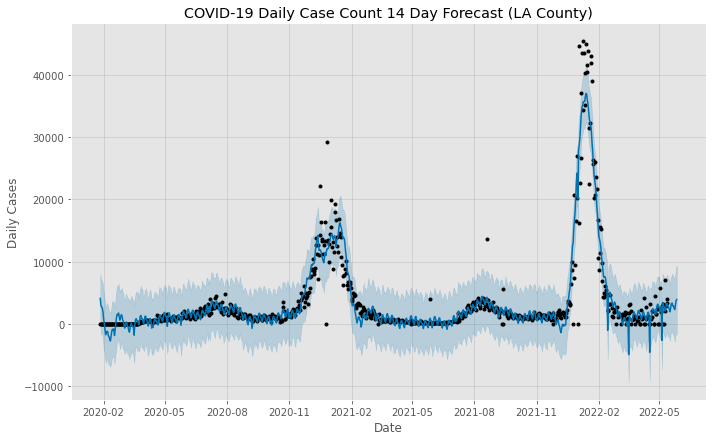

In [93]:
fig = plt.figure(figsize=(20,8))
m.plot(forecast);
plt.title('COVID-19 Daily Case Count 14 Day Forecast (LA County)')
plt.xlabel('Date')
plt.ylabel('Daily Cases')

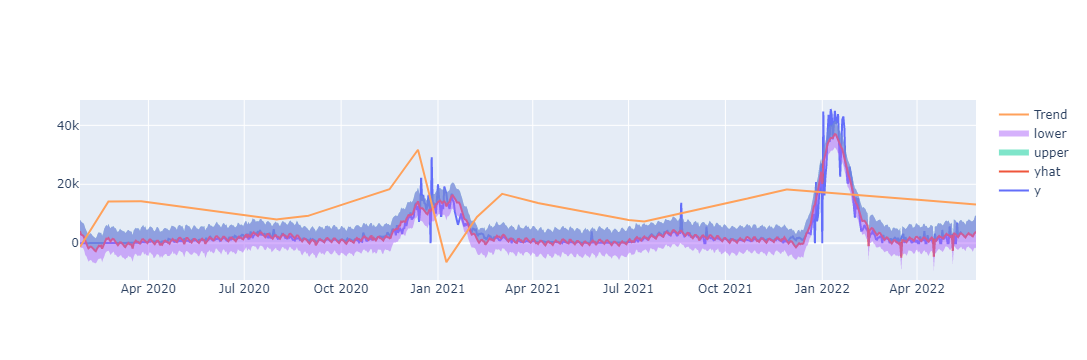

In [105]:
py.iplot([
    go.Scatter(x=los_angeles_prophet['ds'], y=los_angeles_prophet['y'], name='y'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')])


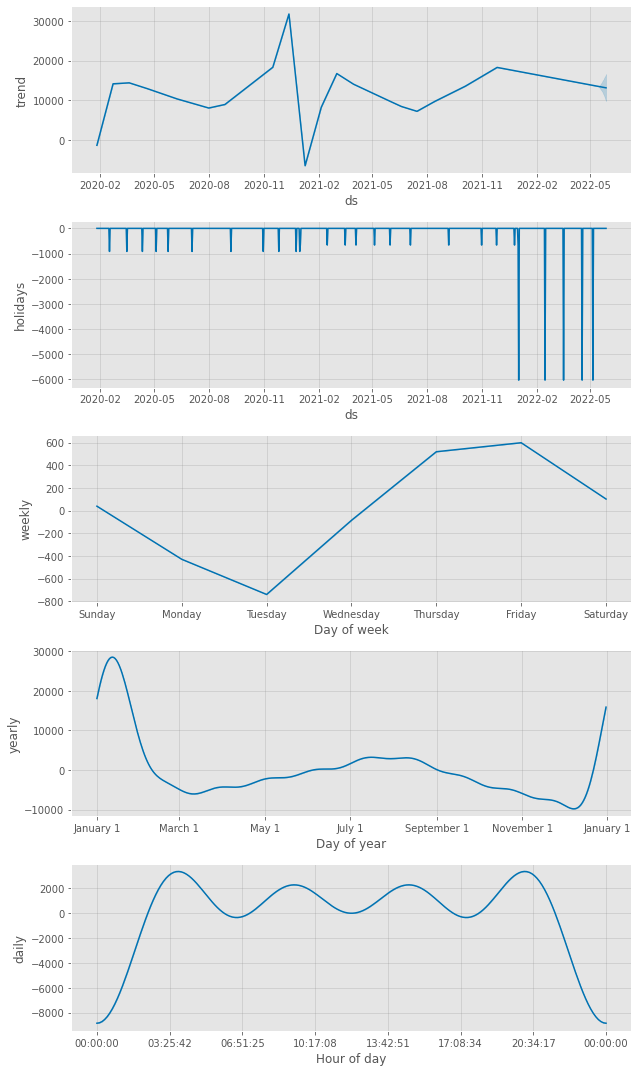

In [101]:
m.plot_components(forecast);

In [102]:
los_angeles_ts_cv = cross_validation(m, horizon='30 days')

INFO:prophet:Making 30 forecasts with cutoffs between 2021-02-02 00:00:00 and 2022-04-13 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

In [103]:
los_angeles_ts_p = performance_metrics(los_angeles_ts_cv)
los_angeles_ts_p.head()

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,3 days,2.181637e+07,4670.800152,2066.810491,0.522843,0.767163,0.855556
1,4 days,3.934976e+07,6272.938876,2802.369587,0.567248,0.844662,0.811111
2,5 days,3.545627e+07,5954.516799,2741.890083,0.556468,0.869605,0.800000
3,6 days,3.651944e+07,6043.131870,2805.454024,0.564603,0.854002,0.788889
4,7 days,2.253963e+07,4747.592153,2330.323846,0.554059,0.838279,0.822222
